In [1]:
# use cellXgene2 conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr, spearmanr, gmean
import statsmodels.formula.api as smf
%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data


# Palettes

In [2]:
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-1])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

<Axes: ylabel='value'>

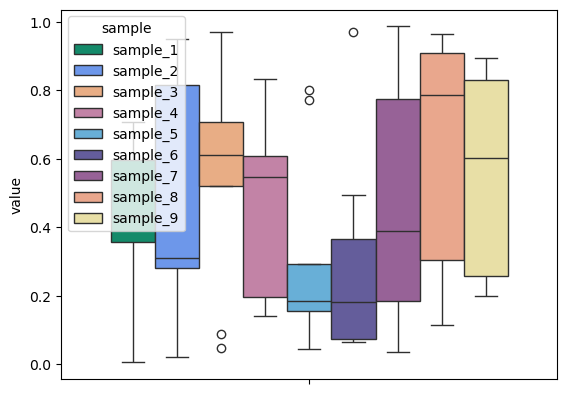

In [7]:
# create random data with 8 samples
np.random.seed(42)
data = np.random.rand(9, 9)
df = pd.DataFrame(data, columns=['sample_{}'.format(i) for i in range(1, 10)])
# pivot long
df = df.melt(var_name='sample', value_name='value')
sns.boxplot(data = df, hue = 'sample', y = 'value', palette = my_categorical_palette)

# Read data

In [119]:
loader = read_data.DatasetLoader("CPTAC-3", load_methylation=False, load_expression=True)
cptac_expr, cptac_mut, _ = loader.load_dataset()
cptac_expr.scale_by_total_seq_depth()
cptac_expr.log_scale_expr()
cptac_expr.expression_df.query("sample_type == 'Primary Tumor'", inplace = True)
cptac_expr.get_dream_gene_expression()
cptac_expr.dream_enrichment_ssgsea()

Loading dataset: CPTAC-3
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_proteomics_kidney_ccrcc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_uterus_ucec_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_proteomics_headneck_hnscc_transpose.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_headneck_hnscc_transpose.parquet
Unknown file type: /cellar/users/zkoc

2024-02-26 11:56:21,374 [WARNING] Input data contains NA, filled NA with 0
2024-02-26 11:56:21,904 [WARNING] Found duplicated gene names, values averaged by gene names!


scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
scaled DREAM_enrichment_score by sequence depth and created DREAM_enrichment_score_resid


In [108]:
# keep only tumors and re-do regression
cptac_expr.expression_df.query("sample_type == 'Primary Tumor'", inplace = True)
cptac_expr.scale_dream_by_seq_depth('DREAM_normalized_enrichment_score')

scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid


In [15]:
cptac_expr.expression_df.cancer_type.value_counts()

cancer_type
Renal cell carcinoma           521
Endometrioid adenocarcinoma    479
Adenocarcinoma                 443
Squamous cell carcinoma        440
Infiltrating duct carcinoma    220
Glioblastoma                   104
Oligodendroglioma                2
Name: count, dtype: int64

# DREAM expression vs. mutation burden

### Get DREAM regulated expression

In [4]:

cptac_expr.dream_expression.groupby('cancer_type')[
    ['mean_dream_reg_expr_resid', 'mean_dream_reg_expr']
    ].corr(method = 'spearman')

mean_dream_reg_expr_resid  \
cancer_type                                                                        
Adenocarcinoma              mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.453228   
Endometrioid adenocarcinoma mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.918971   
Glioblastoma                mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.985405   
Infiltrating duct carcinoma mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.688204   
Oligodendroglioma           mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         1.000000   
Renal cell carcinoma        mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.038705   
Squamous cell carcinoma     mean_dream_reg_expr_resid                   1.000000   
                            mean_dream_reg_expr                         0.880711   

                                                       mean_dream_reg_expr  
cancer_type                                                                 
Adenocarcinoma              mean_dream_reg_expr_resid             0.453228  
                            mean_dream_reg_expr                   1.000000  
Endometrioid adenocarcinoma mean_dream_reg_expr_resid             0.918971  
                            mean_dream_reg_expr                   1.000000  
Glioblastoma                mean_dream_reg_expr_resid             0.985405  
                            mean_dream_reg_expr                   1.000000  
Infiltrating duct carcinoma mean_dream_reg_expr_resid             0.688204  
                            mean_dream_reg_expr                   1.000000  
Oligodendroglioma           mean_dream_reg_expr_resid             1.000000  
                            mean_dream_reg_expr                   1.000000  
Renal cell carcinoma        mean_dream_reg_expr_resid             0.038705  
                            mean_dream_reg_expr                   1.000000  
Squamous cell carcinoma     mean_dream_reg_expr_resid             0.880711  
                            mean_dream_reg_expr                   1.000000

### Dream regulated genes are downregulated in tumors

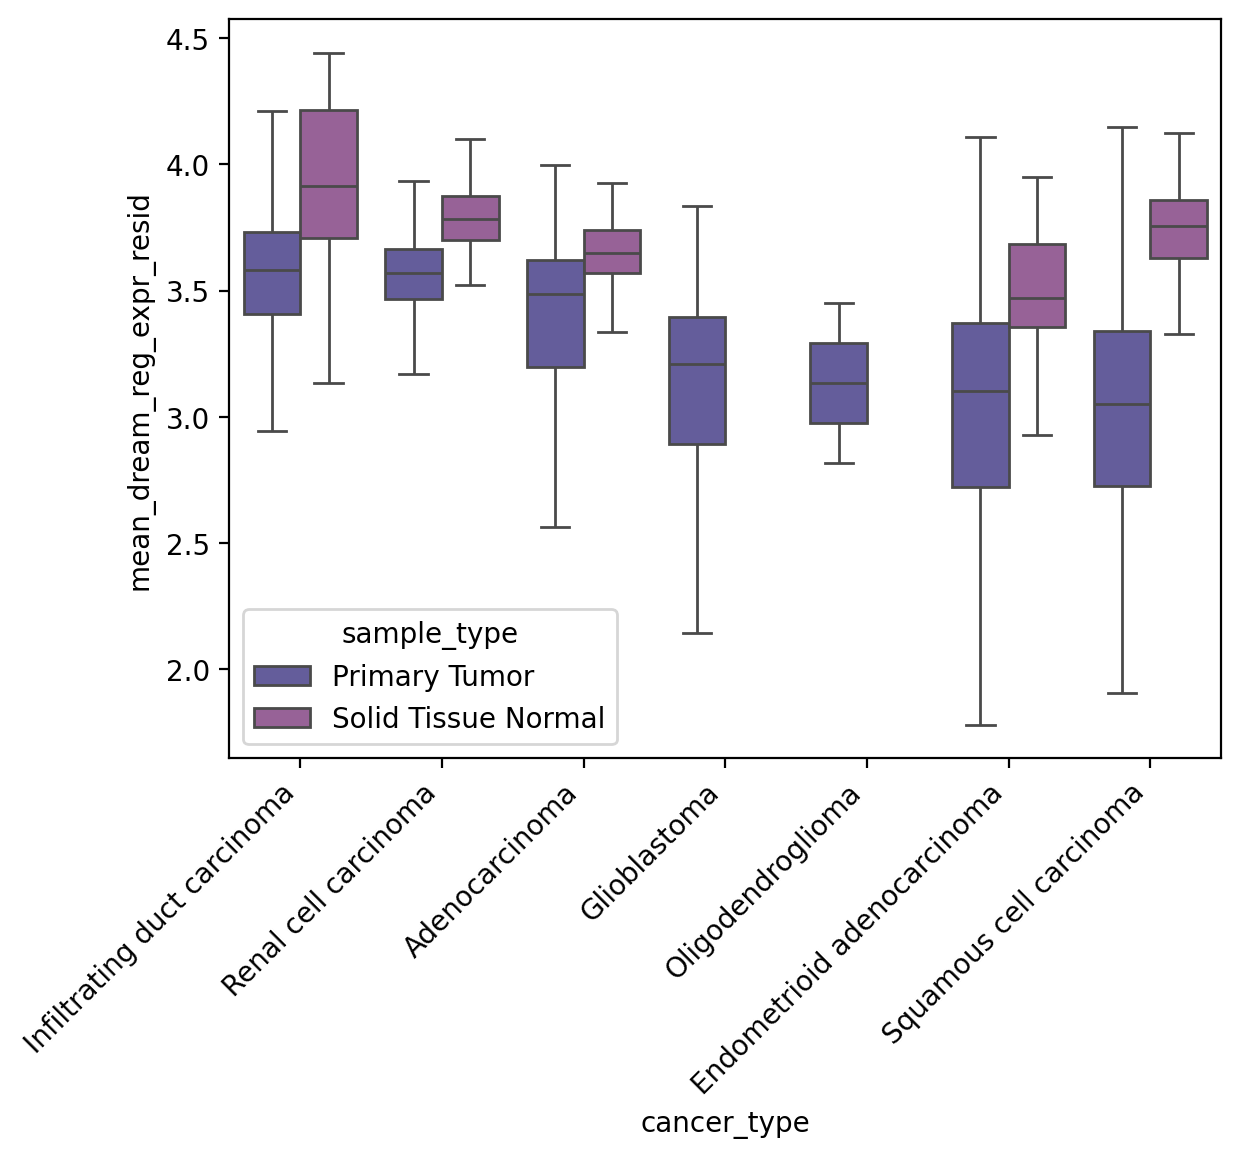

In [17]:
# order by median dream expression in all samples
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('cancer_type')['mean_dream_reg_expr_resid'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression,
    x = 'cancer_type', 
    y = 'mean_dream_reg_expr_resid',
    hue = 'sample_type',
    order = plot_order,
    showfliers = False,
    palette=my_categorical_palette[5:7]
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

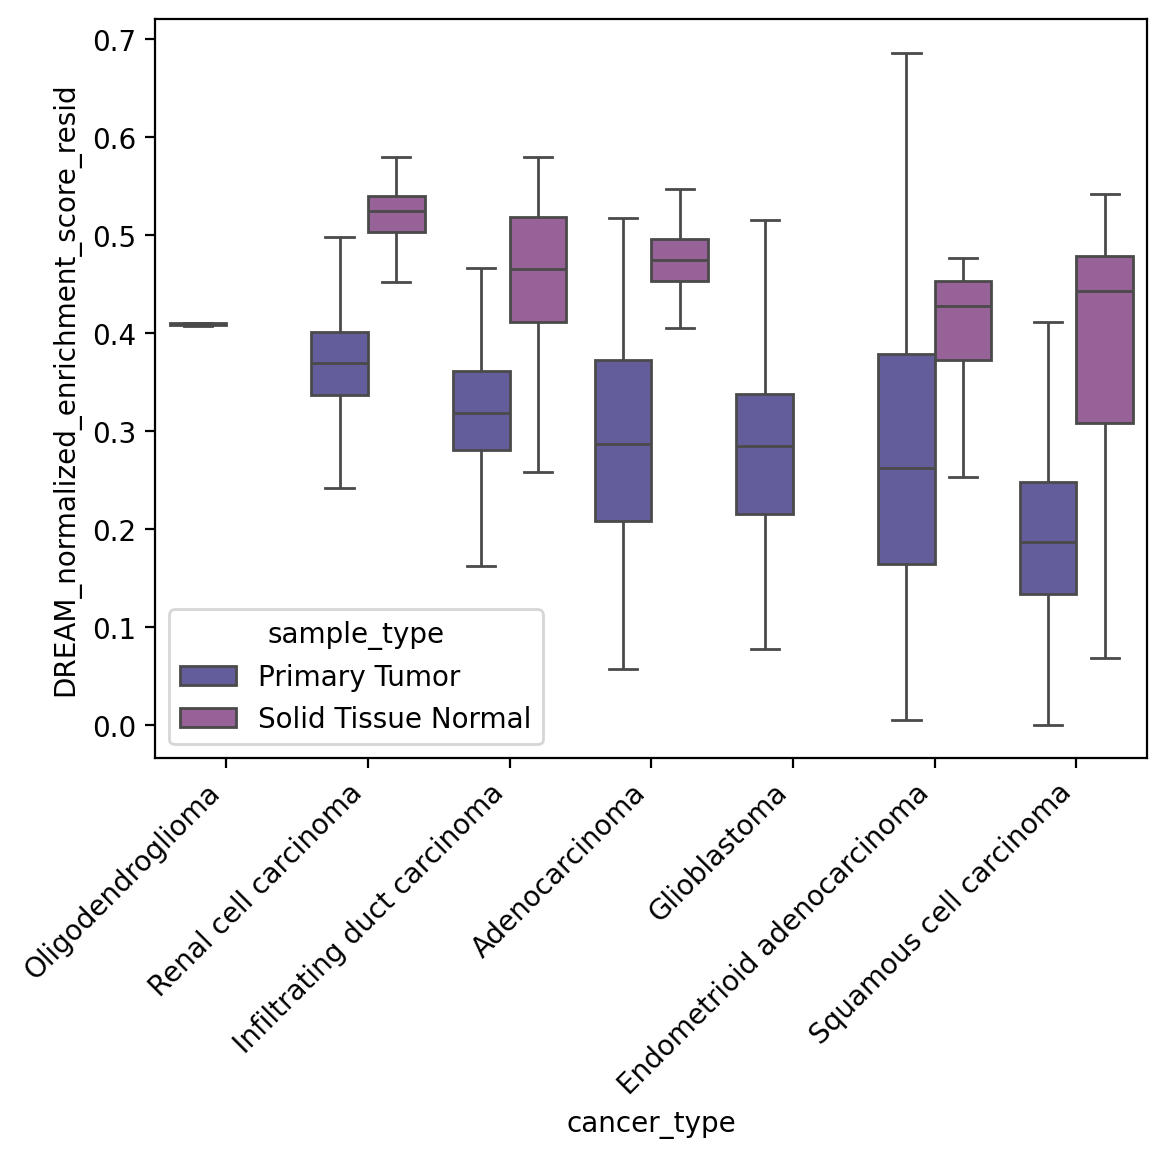

In [20]:
# order by median dream expression in all samples
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('cancer_type')['DREAM_normalized_enrichment_score_resid'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression,
    x = 'cancer_type', 
    y = 'DREAM_normalized_enrichment_score_resid',
    hue = 'sample_type',
    order = plot_order,
    showfliers = False,
    palette=my_categorical_palette[5:7]
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

### Dream regulated gene expression does not change with age

In [21]:
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
spearmanr(normal_tissue_dream_expr['age_at_index'],normal_tissue_dream_expr['DREAM_normalized_enrichment_score_resid'], nan_policy='omit')

SignificanceResult(statistic=-0.03006490682577926, pvalue=0.45783775403726856)

In [22]:
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
spearmanr(normal_tissue_dream_expr['age_at_index'],normal_tissue_dream_expr['DREAM_normalized_enrichment_score_resid'], nan_policy='omit')

SignificanceResult(statistic=-0.03006490682577926, pvalue=0.45783775403726856)

In [23]:
tumor_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'")
spearmanr(tumor_tissue_dream_expr['age_at_index'],tumor_tissue_dream_expr['DREAM_normalized_enrichment_score_resid'], nan_policy='omit')

SignificanceResult(statistic=0.014385124046079407, pvalue=0.5749528667664447)

In [24]:
tumor_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'")
spearmanr(tumor_tissue_dream_expr['age_at_index'],tumor_tissue_dream_expr['DREAM_normalized_enrichment_score_resid'], nan_policy='omit')

SignificanceResult(statistic=0.014385124046079407, pvalue=0.5749528667664447)

### Deconvolving cell-cyle

##### With DREAM reg genes in

In [25]:
# deconvolutuion was done in /cellar/users/zkoch/dream/notebooks/010824_cellCycle_deconv.ipynb
cell_cycle_scores = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet')
# merge with dream expression
cptac_expr.dream_expression = cptac_expr.dream_expression.merge(cell_cycle_scores, left_index=True, right_index=True)

In [27]:
corr_by_sample_type = cptac_expr.dream_expression.groupby('sample_type')[['DREAM_normalized_enrichment_score_resid', 'S_score', 'G2M_score']].corr(method='spearman')
corr_by_sample_type

DREAM_normalized_enrichment_score_resid  \
sample_type                                                                                            
Primary Tumor       DREAM_normalized_enrichment_score_resid                                 1.000000   
                    S_score                                                                -0.733259   
                    G2M_score                                                              -0.798109   
Solid Tissue Normal DREAM_normalized_enrichment_score_resid                                 1.000000   
                    S_score                                                                -0.033172   
                    G2M_score                                                              -0.060106   

                                                              S_score  \
sample_type                                                             
Primary Tumor       DREAM_normalized_enrichment_score_resid -0.733259   
                    S_score                                  1.000000   
                    G2M_score                                0.659201   
Solid Tissue Normal DREAM_normalized_enrichment_score_resid -0.033172   
                    S_score                                  1.000000   
                    G2M_score                                0.255492   

                                                             G2M_score  
sample_type                                                             
Primary Tumor       DREAM_normalized_enrichment_score_resid  -0.798109  
                    S_score                                   0.659201  
                    G2M_score                                 1.000000  
Solid Tissue Normal DREAM_normalized_enrichment_score_resid  -0.060106  
                    S_score                                   0.255492  
                    G2M_score                                 1.000000

In [108]:
cptac_mut.mutation_burden.shape

(1272, 8)

Text(-40, 5, '$\\rho$ = -0.11')

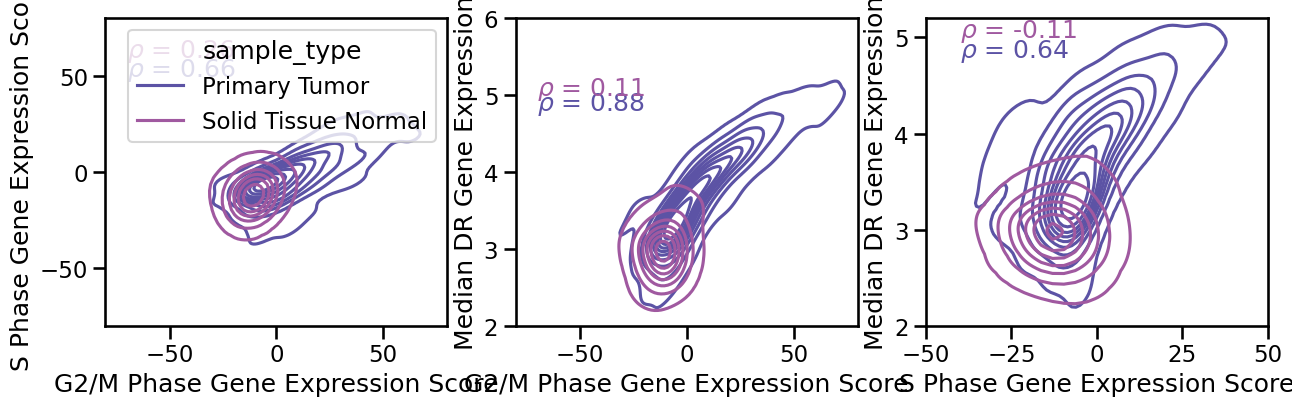

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.set_context('talk')
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score',
    y = 'S_score',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7], 
    ax = axes[0],
    legend = True
    )
# change legend title
axes[0].set_xlim(-80, 80)
axes[0].set_ylim(-80, 80)
axes[0].set_xlabel('G2/M Phase Gene Expression Score')
axes[0].set_ylabel('S Phase Gene Expression Score')
# add the correlation between the two scores for each sample type, use symbol for rho
axes[0].text(-70, 50, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score'),'S_score']), color=my_categorical_palette[5])
axes[0].text(-70, 60, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score'), 'S_score']), color=my_categorical_palette[6])

sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[1]
    )
axes[1].set_xlim(-80, 80)
axes[1].set_ylim(2,6)
axes[1].set_xlabel('G2/M Phase Gene Expression Score')
axes[1].set_ylabel('Median DR Gene Expression')
axes[1].get_legend().remove()
# add the correlation between the two scores for each sample type
axes[1].text(-70, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score'),'median_dream_reg_expr']), color=my_categorical_palette[5])
axes[1].text(-70, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score'), 'median_dream_reg_expr']), color=my_categorical_palette[6])
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'S_score',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[2]
    )

axes[2].set_xlim(-50,50)
axes[2].set_ylim(2,5.2)
axes[2].set_xlabel('S Phase Gene Expression Score')
axes[2].set_ylabel('Median DR Gene Expression')
# remove legend
axes[2].get_legend().remove()
# add the correlation between the two scores for each sample type
axes[2].text(-40, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'S_score'),'median_dream_reg_expr']), color=my_categorical_palette[5])
axes[2].text(-40, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'S_score'), 'median_dream_reg_expr']), color=my_categorical_palette[6])

##### W/out DREAM reg genes

In [ ]:
# deconvolutuion was done in /cellar/users/zkoch/dream/notebooks/010824_cellCycle_deconv.ipynb
cell_cycle_scores = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores_no_DREAM_reg_genes.parquet')
# add _no_dream to the column names
cell_cycle_scores.columns = [col + '_no_dream' for col in cell_cycle_scores.columns]
# merge with dream expression
cptac_expr.dream_expression = cptac_expr.dream_expression.merge(cell_cycle_scores, left_index=True, right_index=True)

In [27]:
corr_by_sample_type = cptac_expr.dream_expression.groupby('sample_type')[['mean_dream_reg_expr', 'median_dream_reg_expr', 'S_score_no_dream', 'G2M_score_no_dream']].corr(method='spearman')
corr_by_sample_type

mean_dream_reg_expr  \
sample_type                                                      
Primary Tumor       mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.988387   
                    S_score_no_dream                  0.852437   
                    G2M_score_no_dream                0.868450   
Solid Tissue Normal mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.938112   
                    S_score_no_dream                  0.725175   
                    G2M_score_no_dream                0.598188   

                                           median_dream_reg_expr  \
sample_type                                                        
Primary Tumor       mean_dream_reg_expr                 0.988387   
                    median_dream_reg_expr               1.000000   
                    S_score_no_dream                    0.839715   
                    G2M_score_no_dream                  0.860955   
Solid Tissue Normal mean_dream_reg_expr                 0.938112   
                    median_dream_reg_expr               1.000000   
                    S_score_no_dream                    0.603150   
                    G2M_score_no_dream                  0.405972   

                                           S_score_no_dream  \
sample_type                                                   
Primary Tumor       mean_dream_reg_expr            0.852437   
                    median_dream_reg_expr          0.839715   
                    S_score_no_dream               1.000000   
                    G2M_score_no_dream             0.865589   
Solid Tissue Normal mean_dream_reg_expr            0.725175   
                    median_dream_reg_expr          0.603150   
                    S_score_no_dream               1.000000   
                    G2M_score_no_dream             0.809851   

                                           G2M_score_no_dream  
sample_type                                                    
Primary Tumor       mean_dream_reg_expr              0.868450  
                    median_dream_reg_expr            0.860955  
                    S_score_no_dream                 0.865589  
                    G2M_score_no_dream               1.000000  
Solid Tissue Normal mean_dream_reg_expr              0.598188  
                    median_dream_reg_expr            0.405972  
                    S_score_no_dream                 0.809851  
                    G2M_score_no_dream               1.000000

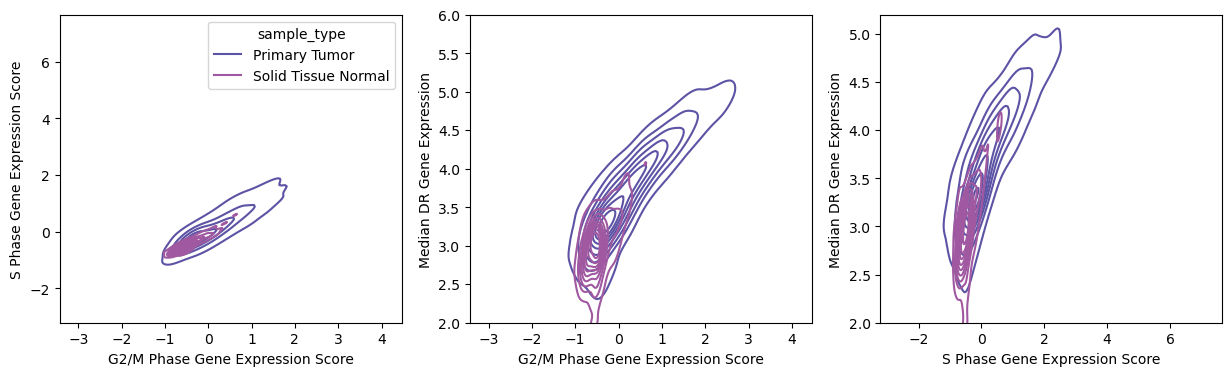

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score_no_dream',
    y = 'S_score_no_dream',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7], 
    ax = axes[0],
    legend = True
    )
#axes[0].set_xlim(-80, 80)
#axes[0].set_ylim(-80, 80)
axes[0].set_xlabel('G2/M Phase Gene Expression Score')
axes[0].set_ylabel('S Phase Gene Expression Score')
# add the correlation between the two scores for each sample type, use symbol for rho
#axes[0].text(-70, 50, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score_no_dream'),'S_score_no_dream']), color=my_categorical_palette[5])
#axes[0].text(-70, 60, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score_no_dream'), 'S_score_no_dream']), color=my_categorical_palette[6])

sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score_no_dream',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[1]
    )
#axes[1].set_xlim(-80, 80)
axes[1].set_ylim(2,6)
axes[1].set_xlabel('G2/M Phase Gene Expression Score')
axes[1].set_ylabel('Median DR Gene Expression')
axes[1].get_legend().remove()
# add the correlation between the two scores for each sample type
#axes[1].text(-70, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score_no_dream'),'median_dream_reg_expr']), color=my_categorical_palette[5])
#axes[1].text(-70, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score_no_dream'), 'median_dream_reg_expr']), color=my_categorical_palette[6])
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'S_score_no_dream',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[2]
    )

#axes[2].set_xlim(-50,50)
axes[2].set_ylim(2,5.2)
axes[2].set_xlabel('S Phase Gene Expression Score')
axes[2].set_ylabel('Median DR Gene Expression')
# remove legend
axes[2].get_legend().remove()
# add the correlation between the two scores for each sample type
#axes[2].text(-40, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'S_score_no_dream'),'median_dream_reg_expr']), color=my_categorical_palette[5])
#axes[2].text(-40, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'S_score_no_dream'), 'median_dream_reg_expr']), color=my_categorical_palette[6])

# Compare with phosphoproteomics

In [32]:
kidney_phospho_df

,NP_000005.2:y708,NP_000007.1:t228,NP_000007.1:t351,NP_000009.1:s485,NP_000009.1:s520,NP_000010.1:s116,NP_000010.1:s167,NP_000010.1:s167t168y170,NP_000010.1:s195,NP_000010.1:s69,...,XP_024304124.1:t1162,XP_024304124.1:t123s124t125,XP_024304124.1:t128s130,XP_024304124.1:t307,XP_024304124.1:t538,XP_024304124.1:t924,XP_024304124.1:t937,XP_024304124.1:t969,XP_024304124.1:y1233,XP_024304124.1:y470
sample_id,,,,,,,,,,,,,,,,,,,,,
NaN,VGFyESDVMGR,AFTGFIVEADtPGIQIGR,RNtYYASIAK,ELsGLGSALK,AGLGSGLsLSGLVHPELSR,QAVLGAGLPIsTPCTTINK,GsTPYGGVK,GstPyGGVKLEDLIVK,IHMGsCAENTAK,LGsIAIQGAIEK,...,KRtLGQGER,NQRPSSMVSEtstAGTASTLEAKPGPK,NQRPSSMVSETSTAGtAsTLEAKPGPK,QAVPQANHtESCHECGR,HGSPtAPICLGSPEFTDQGR,TVPLFPHPPVPSLStSESKPPPQPSPPTSPVR,TVPLFPHPPVPSLSTSESKPPPQPSPPtSPVR,VtSPLQSPTK,VQAMPVTELDLEPQDyDLDISRELSKPEK,QGPGQSLSFPENyQTLPK
NCI7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.02,NaN,...,NaN,NaN,NaN,NaN,NaN,0.57,NaN,NaN,NaN,0.27
NCI7-5,NaN,NaN,NaN,0.83,NaN,NaN,NaN,NaN,0.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCI7-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.04,NaN,...,NaN,NaN,NaN,NaN,-2.56,-1.19,NaN,-0.54,NaN,NaN
NCI7-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-00194-02,NaN,-0.45,NaN,NaN,NaN,NaN,NaN,-1.36,-1.0,NaN,...,-1.39,NaN,NaN,-2.09,NaN,NaN,-1.13,NaN,NaN,NaN
C3N-00495-01,NaN,-0.87,NaN,NaN,NaN,NaN,NaN,NaN,-1.48,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.31,NaN,NaN,NaN,NaN
C3L-00907-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6,NaN,...,NaN,NaN,NaN,-2.35,NaN,-1.32,NaN,NaN,NaN,NaN


In [121]:
# read in phospho data
kidney_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_kidney_ccrcc_transpose.parquet",
    sep = "\t", index_col=0
    )
#kidney_phospho_df.set_index('sample_id', inplace=True, drop=True)

# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(kidney_phospho_df.index)))
kidney_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['DREAM_normalized_enrichment_score_resid', 'sample_type', 'cancer_type']],
     kidney_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )

# read in phospho data
uterus_phospho_df = pd.read_csv(
    "/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_phosphoproteomics_uterus_ucec_transpose.parquet",
    sep = "\t", index_col=0
    )
#uterus_phospho_df.set_index('sample_id', inplace=True, drop=True)

# combine dream and phospho data
samples_w_phospho = list(set(cptac_expr.dream_expression.index).intersection(set(uterus_phospho_df.index)))
uterus_phospho_dream_df = pd.concat(
    [cptac_expr.dream_expression.loc[samples_w_phospho, ['DREAM_normalized_enrichment_score_resid', 'sample_type', 'cancer_type']],
     uterus_phospho_df.loc[samples_w_phospho]],
    axis = 1
    )

phospho_dream_df = pd.concat([kidney_phospho_dream_df, uterus_phospho_dream_df])

/tmp/ipykernel_266274/2966653273.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

In [38]:
# find which lin52 protein to use
# from https://proteomic.datacommons.cancer.gov/pdc/browse and searching the gene
possible_lin52_prot_names = 'G3V5T8;NP_001019845.1;Q52LA3;XP_011535622.1;XP_011535623.1;XP_011535624.2;XP_016877252.1;XP_016877253.1'

"""for prot in possible_lin52_prot_names.split(';'):
    print(prot)
    print(phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(prot)])
    print()"""
lin52_protein = 'NP_001019845.1'
lin52_modifs = phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(lin52_protein)].values

lin52_modifs

array(['NP_001019845.1:s28', 'NP_001019845.1:s53', 'NP_001019845.1:t51'],
      dtype=object)

In [39]:
possible_rbl1_prot_names = 'E9PNB6;H0YE05;NP_001310210.1;NP_001310211.1;NP_002886.2;NP_899662.1;P28749;P28749-2;XP_006723905.1;XP_011527257.1;XP_011527260.1;XP_016883481.1'
"""for prot in possible_rbl1_prot_names.split(';'):
    print(prot)
    print(phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(prot)])
    print()"""
rbl1_protein = 'NP_002886.2'
rbl1_modifs = phospho_dream_df.columns[phospho_dream_df.columns.str.startswith(rbl1_protein)].values
rbl1_modifs

array(['NP_002886.2:s649', 'NP_002886.2:t385', 'NP_002886.2:s1041',
       'NP_002886.2:s640', 'NP_002886.2:s762', 'NP_002886.2:s964',
       'NP_002886.2:s975', 'NP_002886.2:s988', 'NP_002886.2:t332'],
      dtype=object)

### Comparing phosho of DREAM directly with mutations

In [110]:
# combine dream expression and mutation burden
dream_phospho_v_mut_burden = phospho_dream_df.merge(
     cptac_mut.mutation_burden, left_index=True, right_index=True, how='left'
    )
dream_phospho_v_mut_burden.drop(columns = [ 'cancer_type_y'], inplace=True)
dream_phospho_v_mut_burden.rename(columns = {'cancer_type_x': 'cancer_type'}, inplace=True)

In [111]:
dream_phospho_v_mut_burden['NP_001019845.1:s28'] = dream_phospho_v_mut_burden['NP_001019845.1:s28'].astype(float)
dream_phospho_v_mut_burden['mutation_burden'] = dream_phospho_v_mut_burden['mutation_burden'].astype(float)

In [112]:
#to_corr = dream_phospho_v_mut_burden.query("cancer_type == 'Renal cell carcinoma'").dropna(subset = ['mutation_burden', 'NP_001019845.1:s28'])
to_corr = dream_phospho_v_mut_burden.query("cancer_type == 'Endometrioid adenocarcinoma'").dropna(subset = ['mutation_burden', 'NP_001019845.1:s28'])
spearmanr(to_corr['NP_001019845.1:s28'], to_corr['mutation_burden'])

SignificanceResult(statistic=-0.06757519554874607, pvalue=0.6306769539984423)

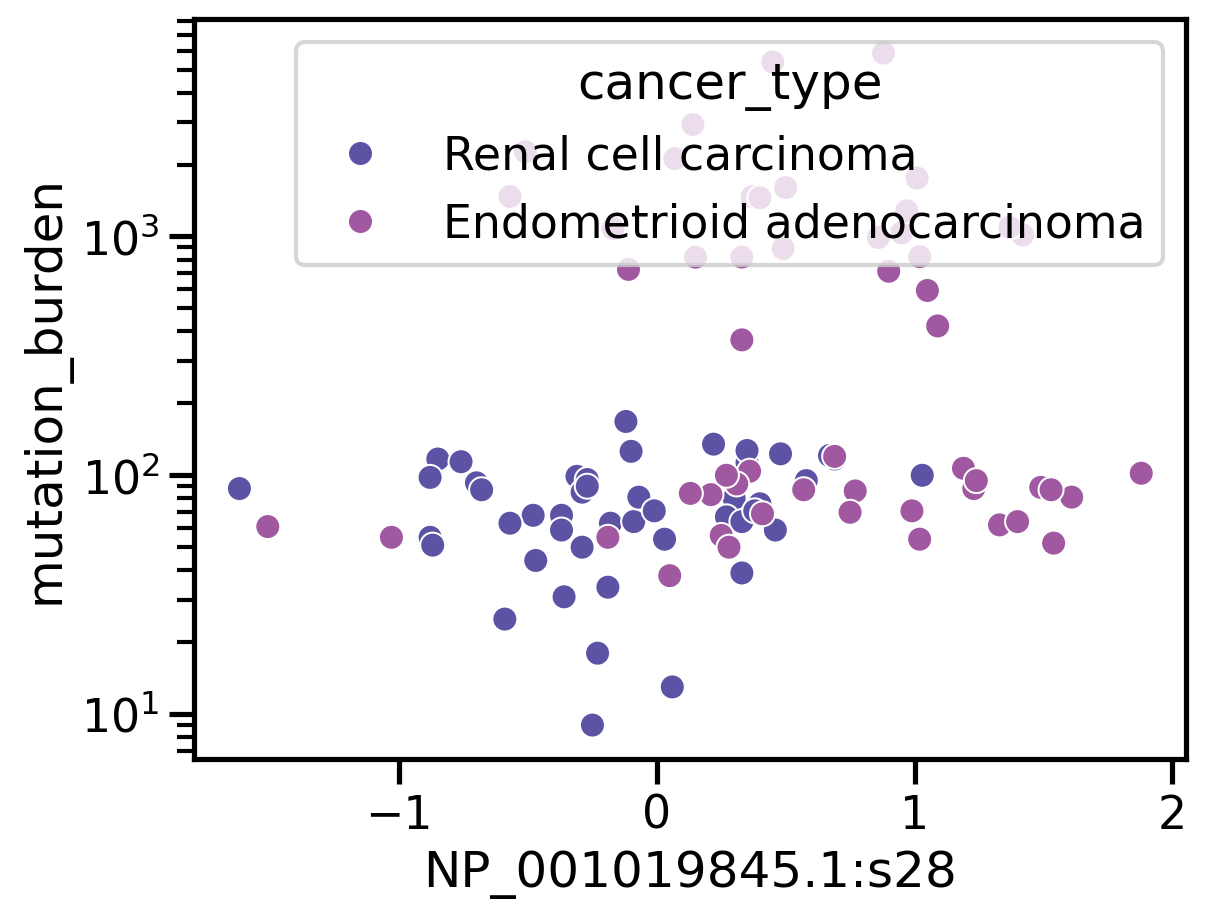

In [113]:
sns.scatterplot(
    data = dream_phospho_v_mut_burden.dropna(subset = ['mutation_burden', 'NP_001019845.1:s28']),
    y = 'mutation_burden',
    x = lin52_modifs[0],
    hue = 'cancer_type',
    
    palette=my_categorical_palette[5:7]
    )
plt.yscale('log')

In [114]:
lin52_col = lin52_modifs[0]
# get non-na value for pearsonr
dream_non_nan = dream_phospho_v_mut_burden[(~dream_phospho_v_mut_burden['mutation_burden'].isna())]
lin52_non_nan = dream_phospho_v_mut_burden[(~dream_phospho_v_mut_burden[lin52_col].isna())]
shared_samples = list(set(dream_non_nan.index).intersection(set(lin52_non_nan.index)))

pearsonr(dream_non_nan.loc[shared_samples, 'mutation_burden'], lin52_non_nan.loc[shared_samples, lin52_col])

PearsonRResult(statistic=0.1324124162092187, pvalue=0.19137725510632203)

### Comparing phoshp with DREAM expr signature

In [81]:
# only s28 is trustworthy
(~phospho_dream_df[lin52_modifs].isna()).sum()

NP_001019845.1:s28    295
NP_001019845.1:s53      7
NP_001019845.1:t51     19
dtype: int64

In [82]:
# rbl1
(~phospho_dream_df[rbl1_modifs].isna()).sum()

NP_002886.2:s649      9
NP_002886.2:t385     81
NP_002886.2:s1041    24
NP_002886.2:s640     46
NP_002886.2:s762     16
NP_002886.2:s964      7
NP_002886.2:s975     23
NP_002886.2:s988     15
NP_002886.2:t332     79
dtype: int64

In [123]:
phospho_dream_df.groupby(['sample_type', 'cancer_type'])[['NP_001019845.1:s28','DREAM_normalized_enrichment_score_resid']].corr(method='spearman')

NP_001019845.1:s28  \
sample_type   cancer_type                                                                               
Primary Tumor Endometrioid adenocarcinoma NP_001019845.1:s28                                 1.000000   
                                          DREAM_normalized_enrichment_score_resid           -0.125822   
              Renal cell carcinoma        NP_001019845.1:s28                                 1.000000   
                                          DREAM_normalized_enrichment_score_resid           -0.081567   

                                                                                   DREAM_normalized_enrichment_score_resid  
sample_type   cancer_type                                                                                                   
Primary Tumor Endometrioid adenocarcinoma NP_001019845.1:s28                                                     -0.125822  
                                          DREAM_normalized_enrichment_score_resid                                 1.000000  
              Renal cell carcinoma        NP_001019845.1:s28                                                     -0.081567  
                                          DREAM_normalized_enrichment_score_resid                                 1.000000

In [124]:
lin52_col = lin52_modifs[0]
# get non-na value for pearsonr
dream_non_nan = phospho_dream_df[(~phospho_dream_df['DREAM_normalized_enrichment_score_resid'].isna())]
lin52_non_nan = phospho_dream_df[(~phospho_dream_df[lin52_col].isna())]
shared_samples = list(set(dream_non_nan.index).intersection(set(lin52_non_nan.index)))

pearsonr(dream_non_nan.loc[shared_samples, 'DREAM_normalized_enrichment_score_resid'], lin52_non_nan.loc[shared_samples, lin52_col])

PearsonRResult(statistic=-0.31374222957502773, pvalue=2.0599070383132047e-06)

In [126]:
phospho_dream_df['NP_001019845.1:s28'] = phospho_dream_df['NP_001019845.1:s28'].astype(float)

<Axes: xlabel='DREAM_normalized_enrichment_score_resid', ylabel='NP_001019845.1:s28'>

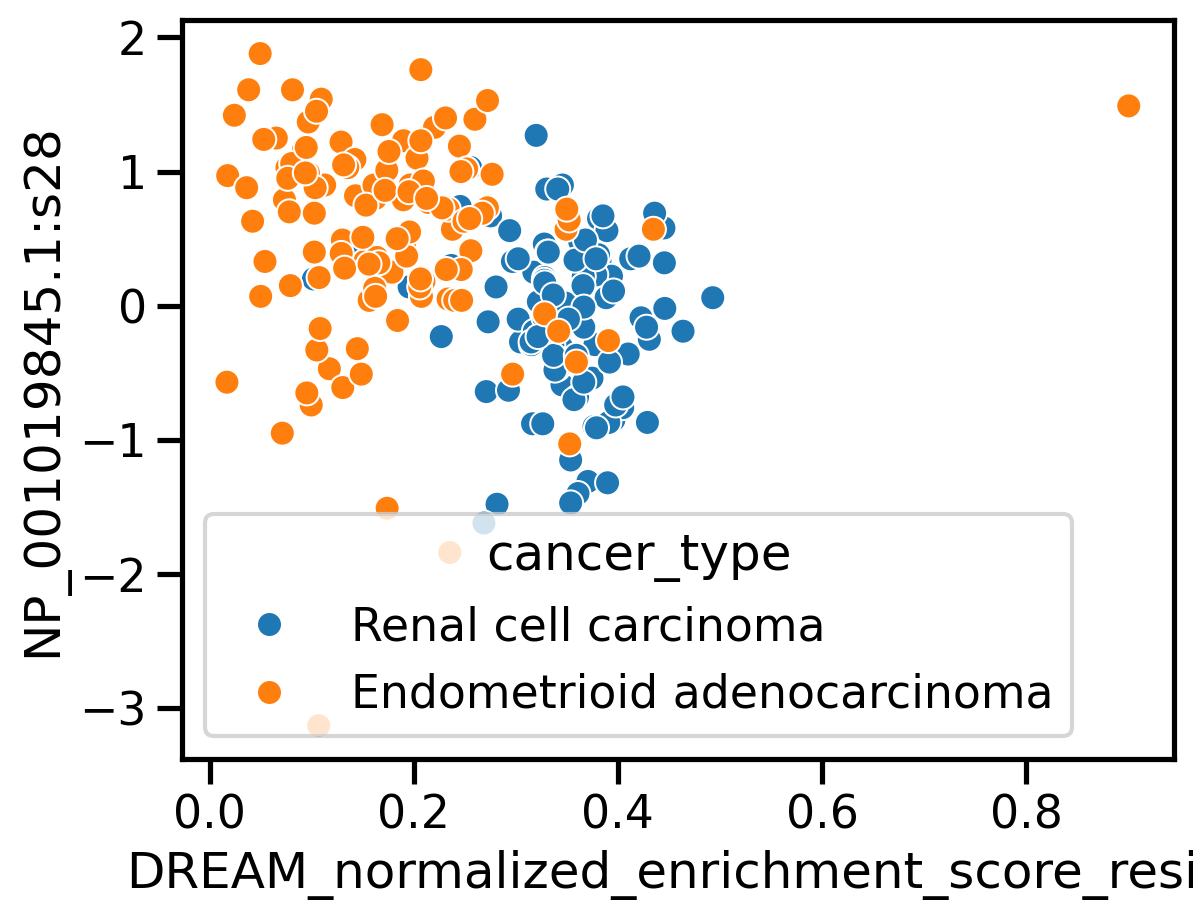

In [127]:
sns.scatterplot(
    data = phospho_dream_df,
    x = 'DREAM_normalized_enrichment_score_resid',
    y = lin52_modifs[0],
    hue = 'cancer_type',
    #palette=my_categorical_palette[5:7]
    )

### Get mutation burdens

/tmp/ipykernel_266274/644110067.py:1: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.scatterplot(


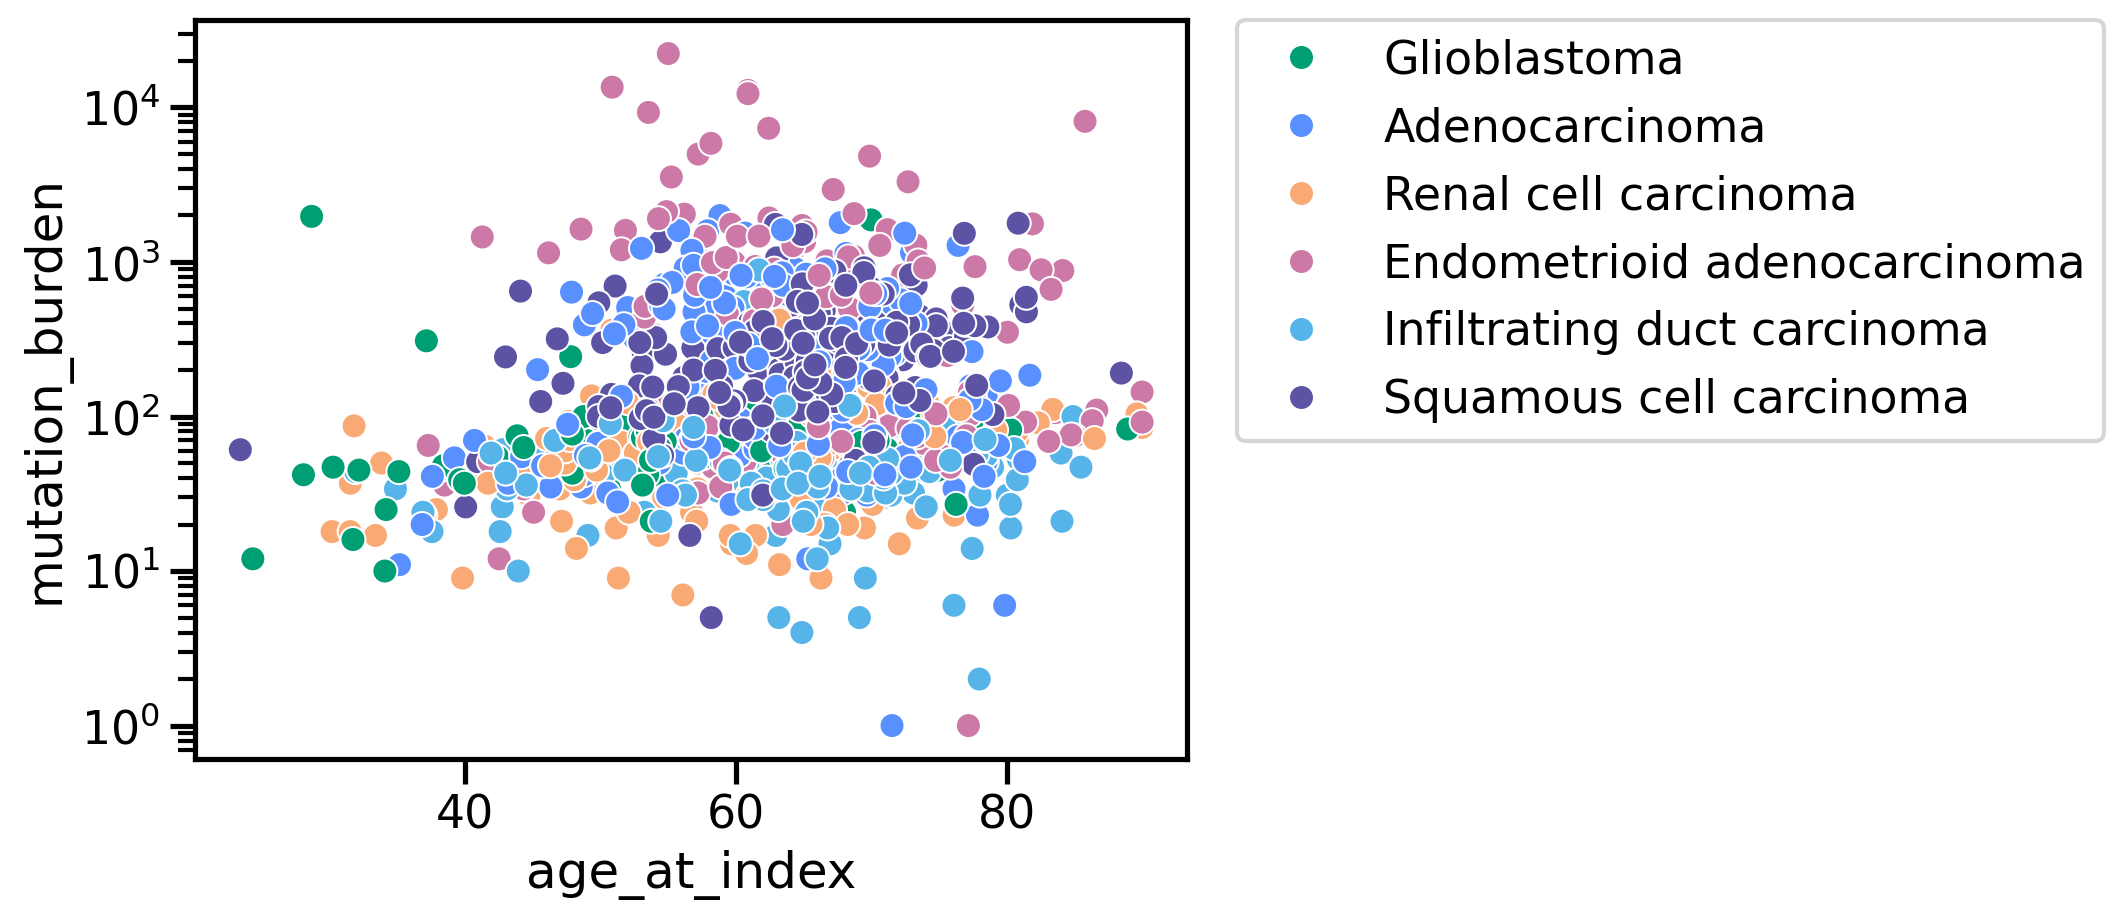

In [128]:
sns.scatterplot(
    data = cptac_mut.mutation_burden.query("num_samples_this_case == 1"),
    x = 'age_at_index', y = 'mutation_burden', hue = 'cancer_type', 
    palette=my_categorical_palette, 
)
plt.yscale('log')
# move legend onto plot
_ =plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Compare dream expression to mutation burden across tissue

<Axes: xlabel='tissue', ylabel='normalized_value'>

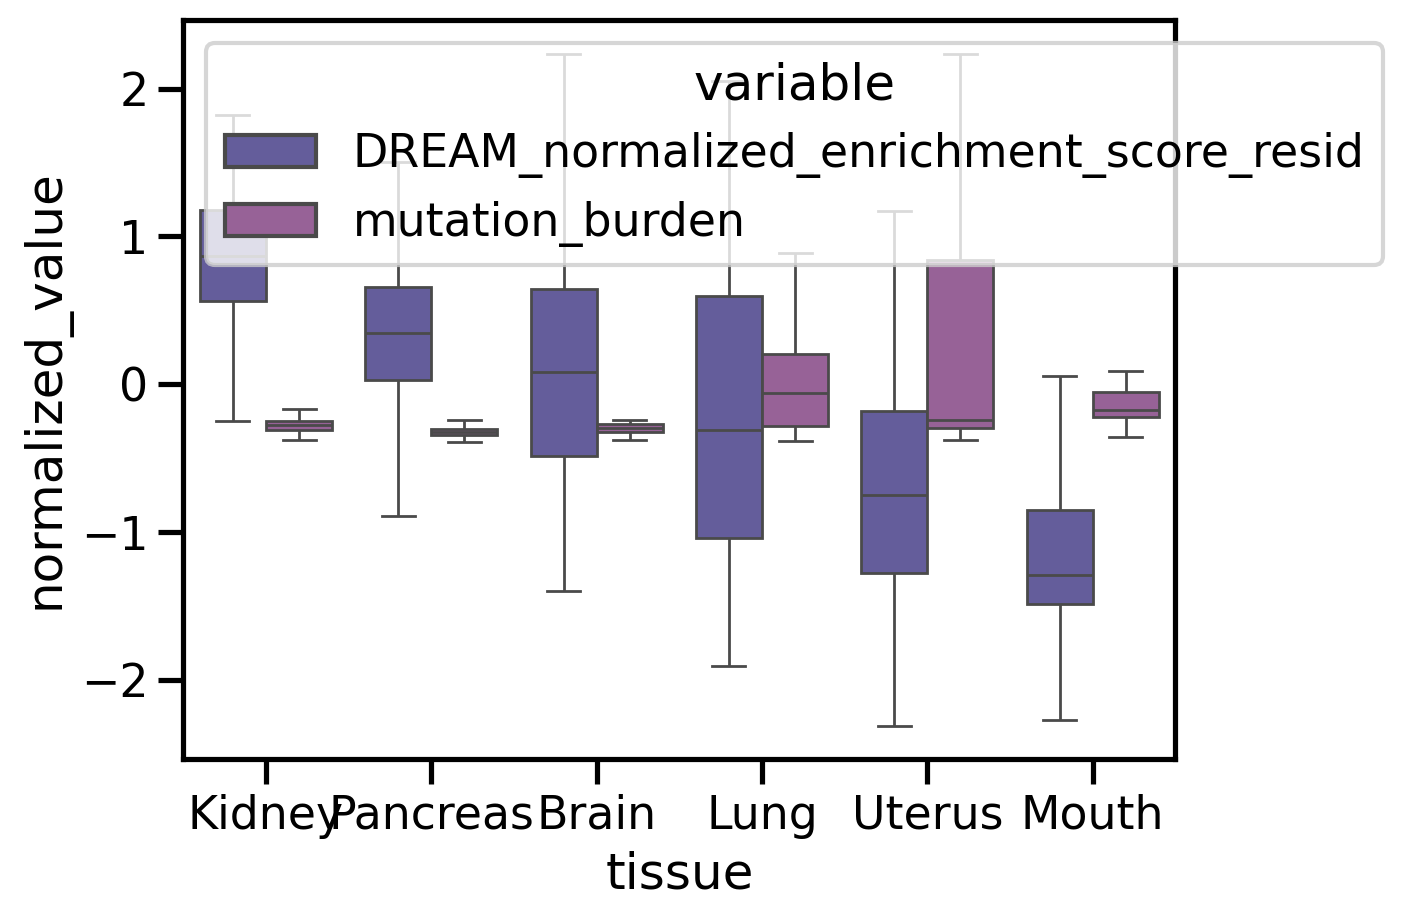

In [132]:
# combine dream expression and mutation burden
dream_exp_v_mut_burden = cptac_expr.dream_expression.merge(
     cptac_mut.mutation_burden, left_index=True, right_index=True, how='left'
    )
# remove _x columns
dream_exp_v_mut_burden = dream_exp_v_mut_burden.loc[:,~dream_exp_v_mut_burden.columns.str.endswith('_x')]
# remive _x from column names
dream_exp_v_mut_burden.columns = dream_exp_v_mut_burden.columns.str.rstrip('_y')
tumor_expr_v_burden = dream_exp_v_mut_burden.dropna(subset=['mutation_burden'])
# want rows with tissue, mean_dream_reg_expr, and mutation_burden
tumor_expr_v_burden_long = tumor_expr_v_burden.melt(
    id_vars = ['case_id', 'tissue', 'age_at_index'],
    value_vars = ['mutation_burden', 'DREAM_normalized_enrichment_score_resid'],
    var_name = 'variable',
    value_name = 'value'
    )
# normalize within each variable value 
tumor_expr_v_burden_long['normalized_value'] = tumor_expr_v_burden_long.groupby('variable')['value'].transform(lambda x: (x - x.mean()) / x.std())
# set order based on normalized dream expression
orderr = tumor_expr_v_burden.groupby('tissue')['DREAM_normalized_enrichment_score_resid'].median().sort_values(ascending=False).index
sns.boxplot(
    data = tumor_expr_v_burden_long, hue = 'variable', x = 'tissue', y = 'normalized_value',
    palette=my_categorical_palette[5:7],  order = orderr, showfliers=False,
    hue_order=['DREAM_normalized_enrichment_score_resid', 'mutation_burden',]
    )


### Compare dream expression to mutation burden within each tissue

In [133]:
tumor_expr_v_burden.groupby('tissue')[
    ['mutation_burden', 'DREAM_normalized_enrichment_score_resid']
    ].corr(method='spearman')

mutation_burden  \
tissue                                                              
Brain    mutation_burden                                 1.000000   
         DREAM_normalized_enrichment_score_resid        -0.345298   
Kidney   mutation_burden                                 1.000000   
         DREAM_normalized_enrichment_score_resid        -0.163253   
Lung     mutation_burden                                 1.000000   
         DREAM_normalized_enrichment_score_resid        -0.545291   
Mouth    mutation_burden                                 1.000000   
         DREAM_normalized_enrichment_score_resid        -0.361787   
Pancreas mutation_burden                                 1.000000   
         DREAM_normalized_enrichment_score_resid        -0.354487   
Uterus   mutation_burden                                 1.000000   
         DREAM_normalized_enrichment_score_resid        -0.416876   

                                                  DREAM_normalized_enrichment_score_resid  
tissue                                                                                     
Brain    mutation_burden                                                        -0.345298  
         DREAM_normalized_enrichment_score_resid                                 1.000000  
Kidney   mutation_burden                                                        -0.163253  
         DREAM_normalized_enrichment_score_resid                                 1.000000  
Lung     mutation_burden                                                        -0.545291  
         DREAM_normalized_enrichment_score_resid                                 1.000000  
Mouth    mutation_burden                                                        -0.361787  
         DREAM_normalized_enrichment_score_resid                                 1.000000  
Pancreas mutation_burden                                                        -0.354487  
         DREAM_normalized_enrichment_score_resid                                 1.000000  
Uterus   mutation_burden                                                        -0.416876  
         DREAM_normalized_enrichment_score_resid                                 1.000000

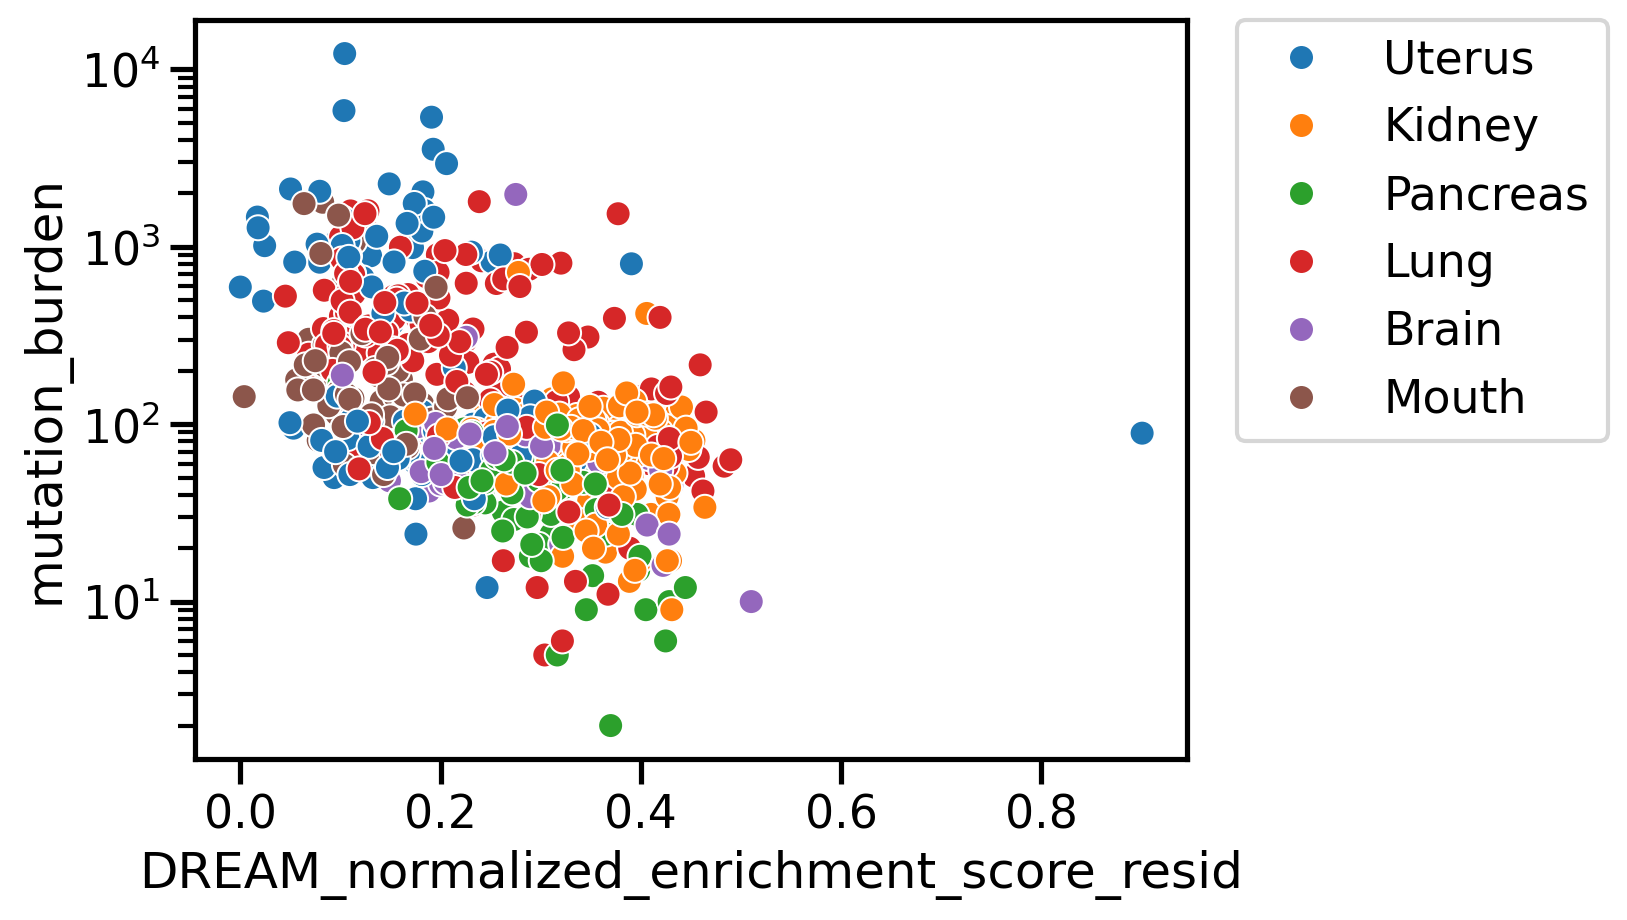

In [135]:
sns.scatterplot(
    data = tumor_expr_v_burden,
    y = 'mutation_burden', x = 'DREAM_normalized_enrichment_score_resid', hue = 'tissue',
)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/tmp/ipykernel_266274/167646318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'DREAM_normalized_enrichment_score_resid':'DREAM complex activity'
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/cellXgene2/lib/python3.8/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


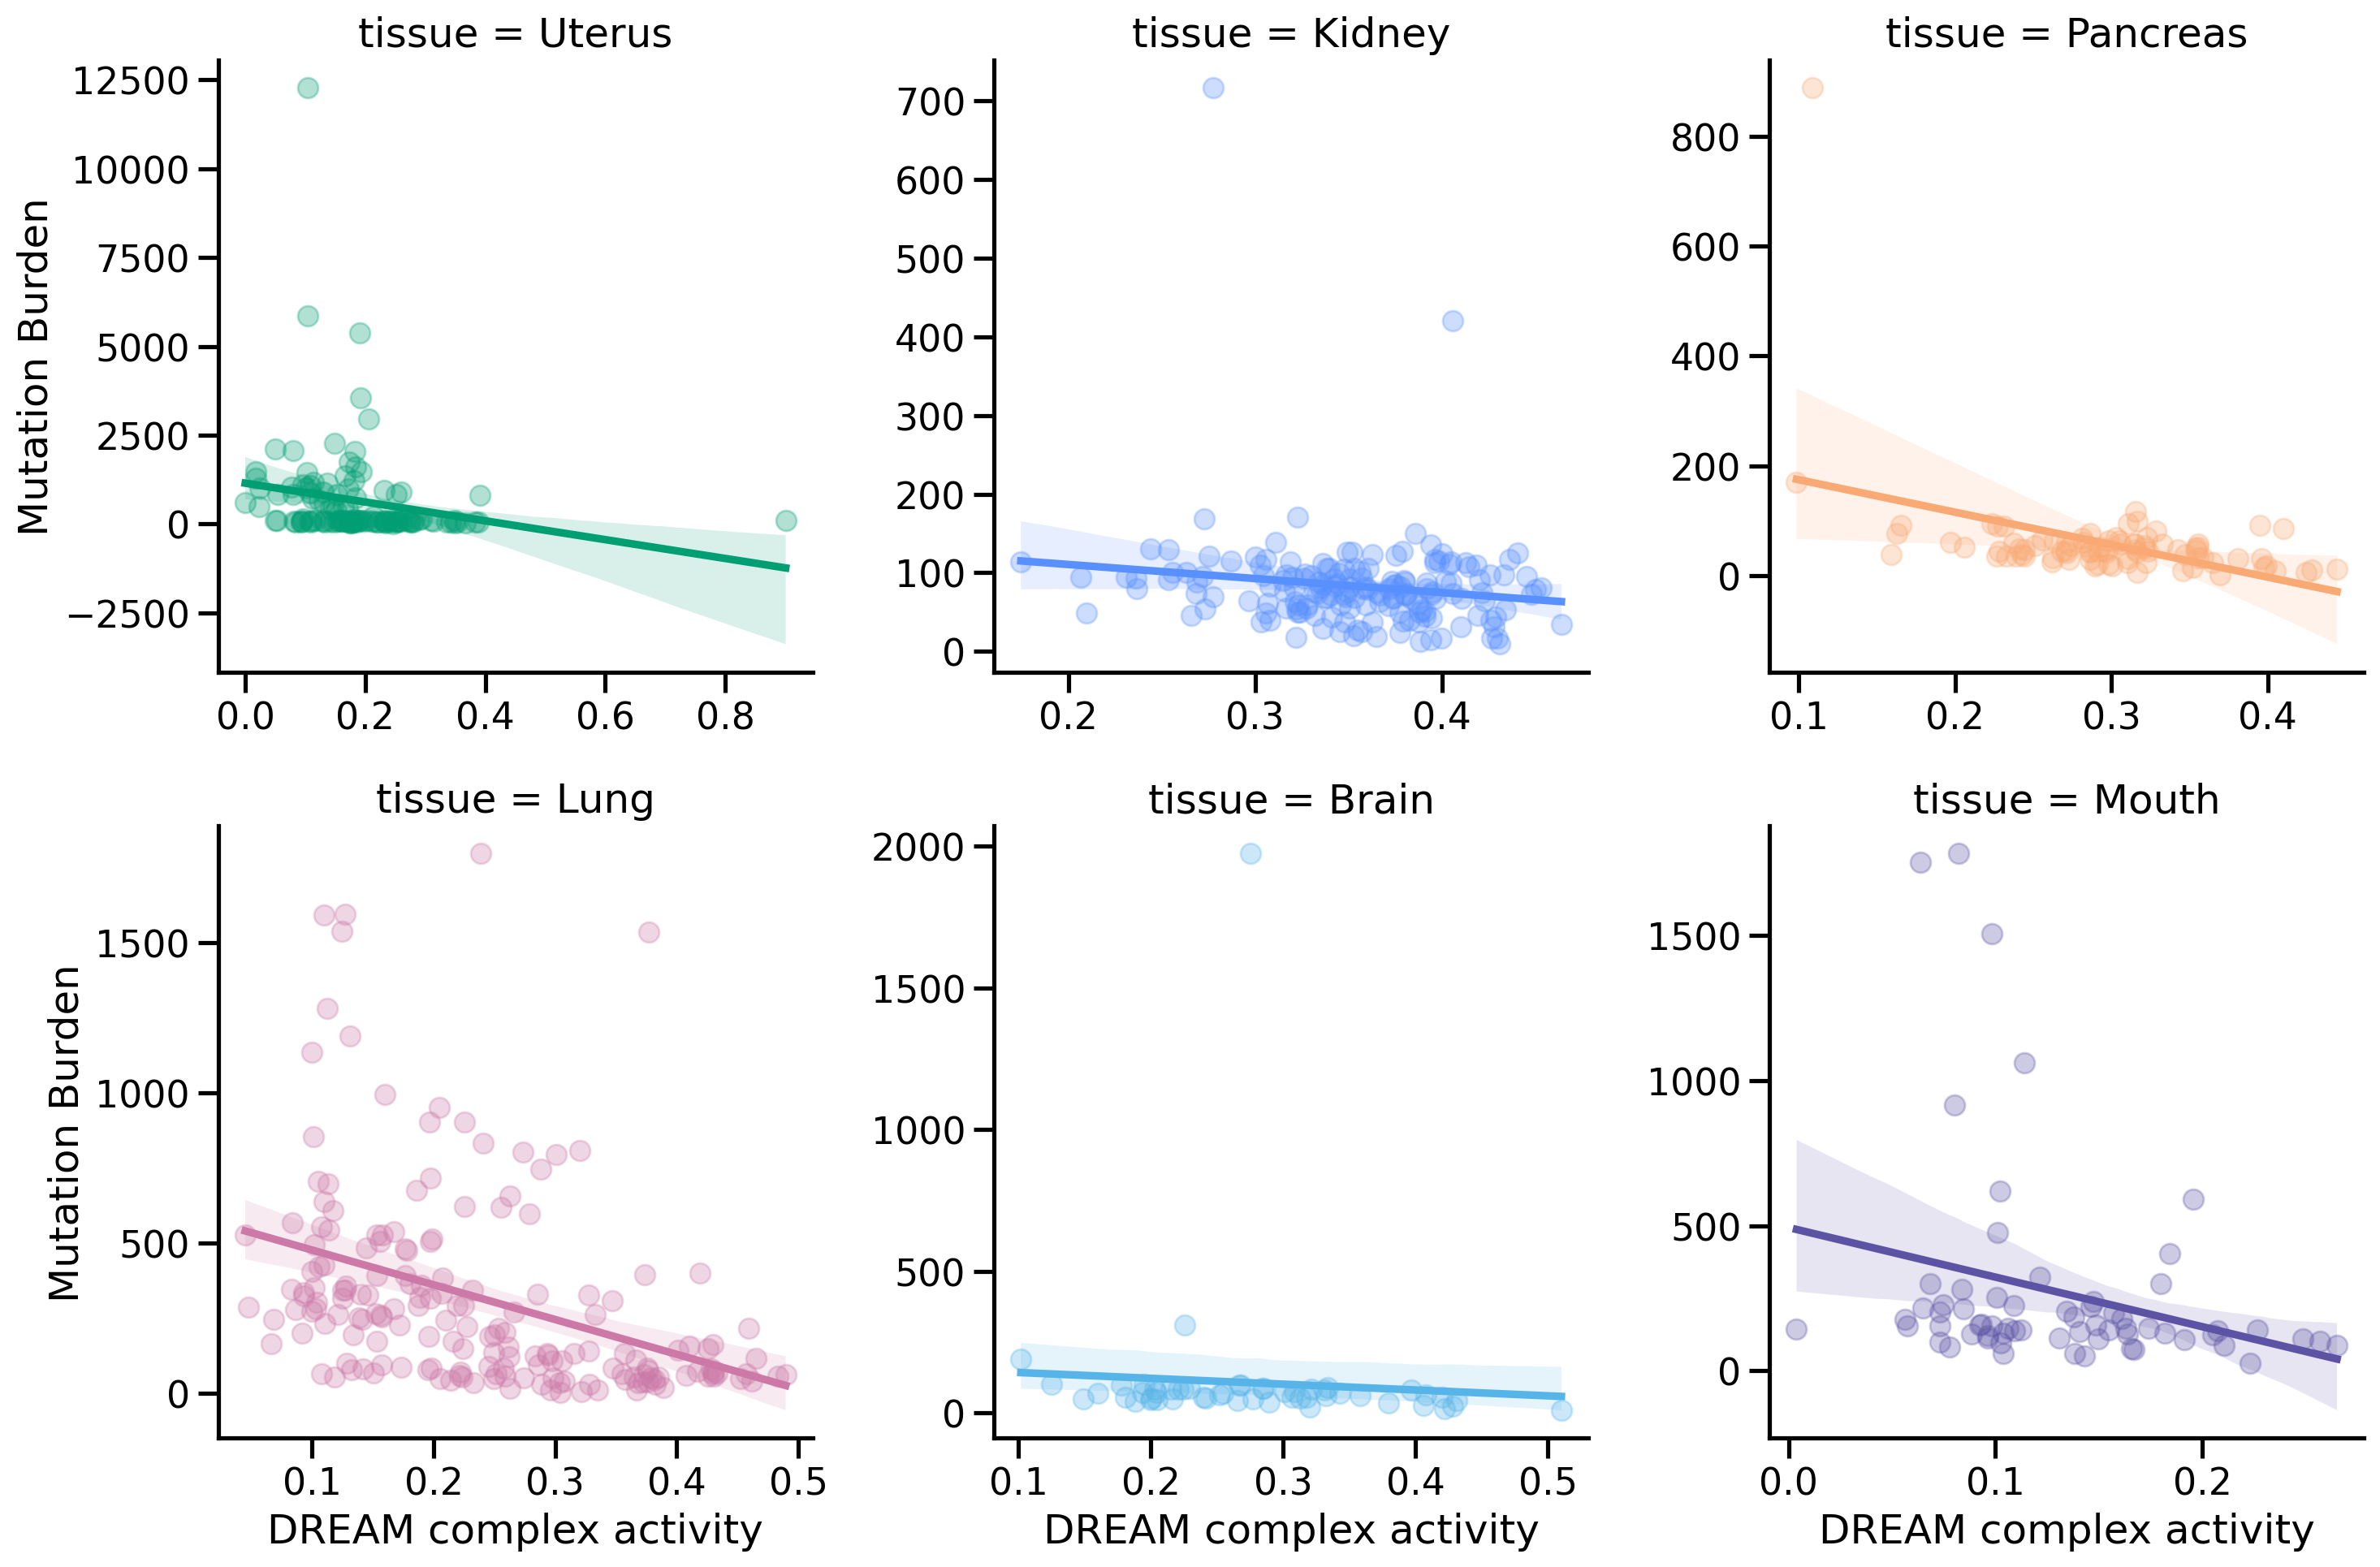

In [136]:
# get the linear equations from the regression
sns.set_context('talk')
tumor_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'DREAM_normalized_enrichment_score_resid':'DREAM complex activity'
                                    }, inplace=True)
sns.lmplot(
    data = tumor_expr_v_burden,
    x = 'DREAM complex activity', y = 'Mutation Burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    col_wrap=3,
)



In [87]:
# robust linear model from formula
from statsmodels.robust.robust_linear_model import RLM
# fit robust linear model
robust_model = RLM.from_formula(' mutation_burden~ age_at_index*tissue', data=tumor_expr_v_burden)
results = robust_model.fit()

In [90]:
results.params

Intercept                          53.157737
tissue[T.Kidney]                  -46.801124
tissue[T.Lung]                    -52.467586
tissue[T.Mouth]                   -98.178715
tissue[T.Pancreas]                 -1.056912
tissue[T.Uterus]                   57.753861
age_at_index                        0.261932
age_at_index:tissue[T.Kidney]       0.889271
age_at_index:tissue[T.Lung]         3.073734
age_at_index:tissue[T.Mouth]        3.191867
age_at_index:tissue[T.Pancreas]    -0.311448
age_at_index:tissue[T.Uterus]       0.017422
dtype: float64

In [91]:
mutation_rate = {'Kidney': 0.261932 + 0.889271, 'Lung': 0.261932 + 3.073734, 'Mouth': 0.261932 + 3.191867, 'Pancreas': 0.261932 + 0.311448, 'Uterus': 0.261932 + 0.017422}

/tmp/ipykernel_348296/2556682373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden['Somatic mutation rate (per year)'] = tumor_expr_v_burden['tissue'].map(mutation_rate)


<Axes: xlabel='Somatic mutation rate (per year)', ylabel='mean_dream_reg_expr'>

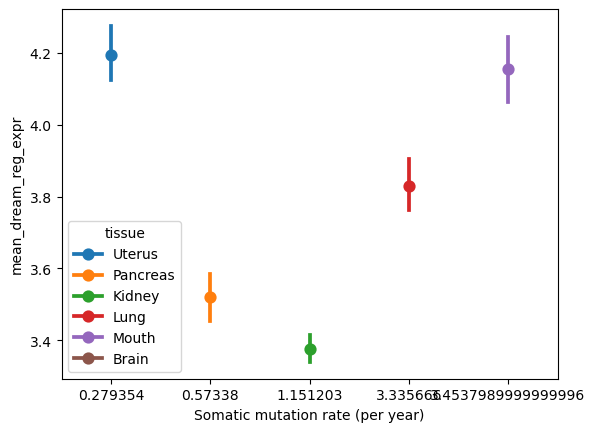

In [97]:
tumor_expr_v_burden['Somatic mutation rate (per year)'] = tumor_expr_v_burden['tissue'].map(mutation_rate)
sns.pointplot(
    data = tumor_expr_v_burden,
    x = 'Somatic mutation rate (per year)', y = 'mean_dream_reg_expr', hue = 'tissue',
)

In [99]:
normal_expr_v_burden[['Somatic mutation rate (per year)', 'mean_dream_reg_expr']].corr()

,Somatic mutation rate (per year),mean_dream_reg_expr
Somatic mutation rate (per year),1.000000,0.328777
mean_dream_reg_expr,0.328777,1.000000


<Axes: xlabel='Somatic mutation rate (per year)', ylabel='mean_dream_reg_expr'>

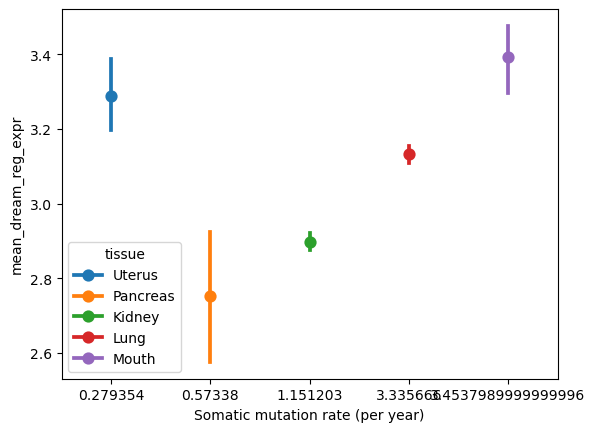

In [98]:
normal_expr_v_burden['Somatic mutation rate (per year)'] = normal_expr_v_burden['tissue'].map(mutation_rate)
sns.pointplot(
    data = normal_expr_v_burden,
    x = 'Somatic mutation rate (per year)', y = 'mean_dream_reg_expr', hue = 'tissue',
)

/tmp/ipykernel_348296/3633096871.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


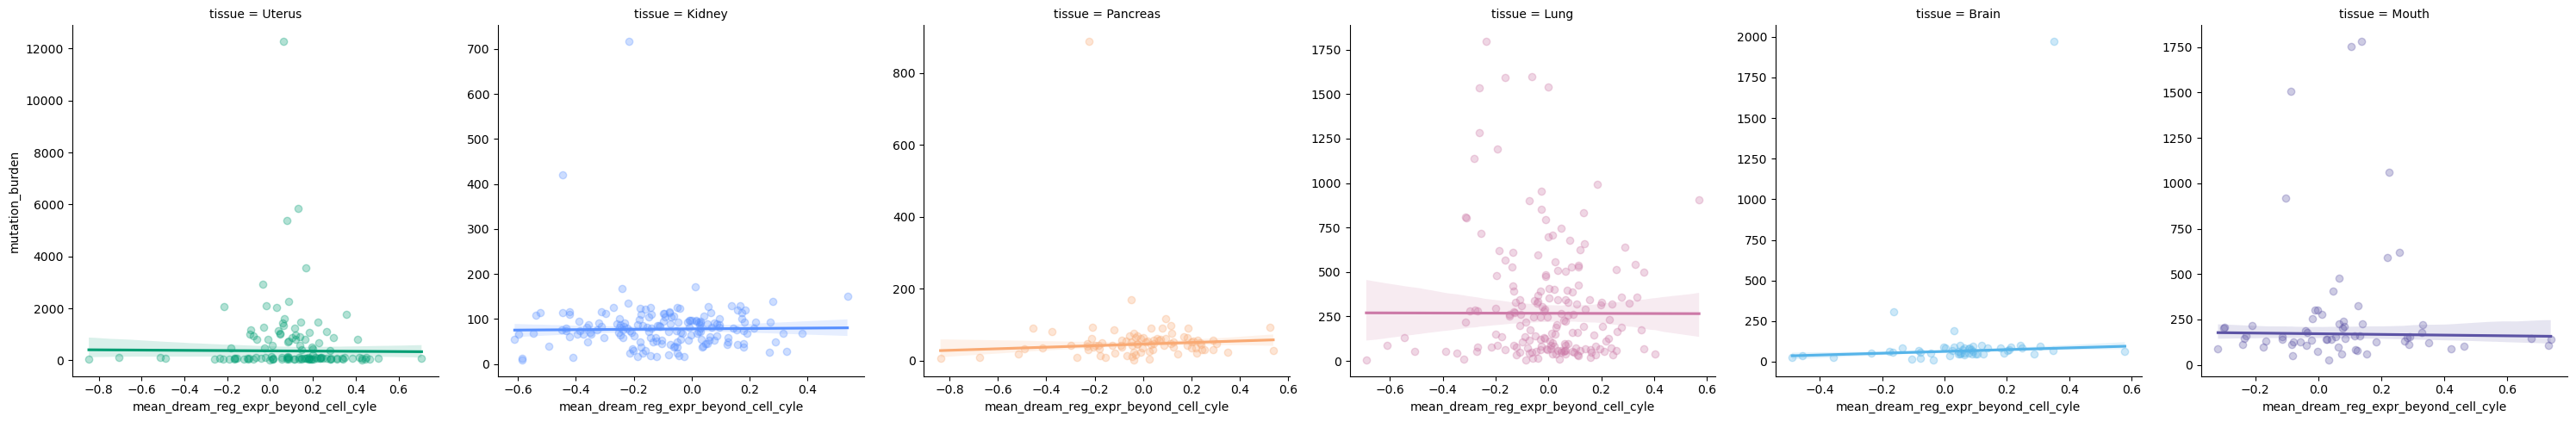

In [100]:

# control dream expression for S_score
# fit linear model
model = smf.ols(formula='mean_dream_reg_expr ~ S_score * G2M_score', data=tumor_expr_v_burden)
results = model.fit()
# add residuals to dataframe
tumor_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
sns.lmplot(
    data = tumor_expr_v_burden,
    x = 'mean_dream_reg_expr_beyond_cell_cyle', y = 'mutation_burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    robust  = True,
)

/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


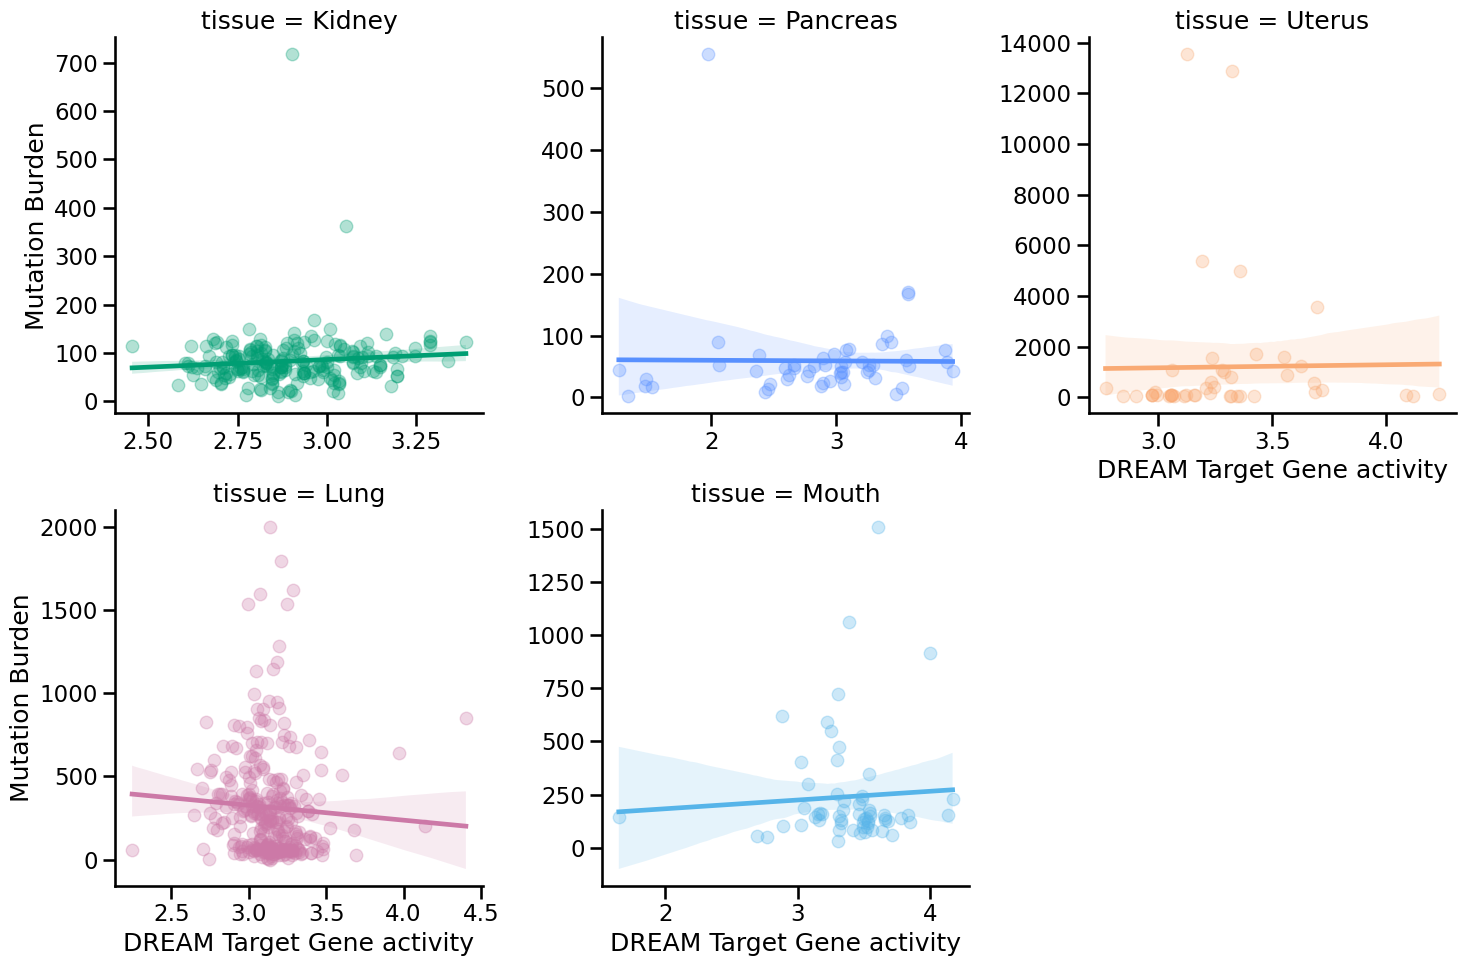

In [111]:

# get the linear equations from the regression
sns.set_context('talk')
normal_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr':'DREAM Target Gene activity'
                                    }, inplace=True)
sns.lmplot(
    data = normal_expr_v_burden,
    x = 'DREAM Target Gene activity', y = 'Mutation Burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    col_wrap=3,
)



/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


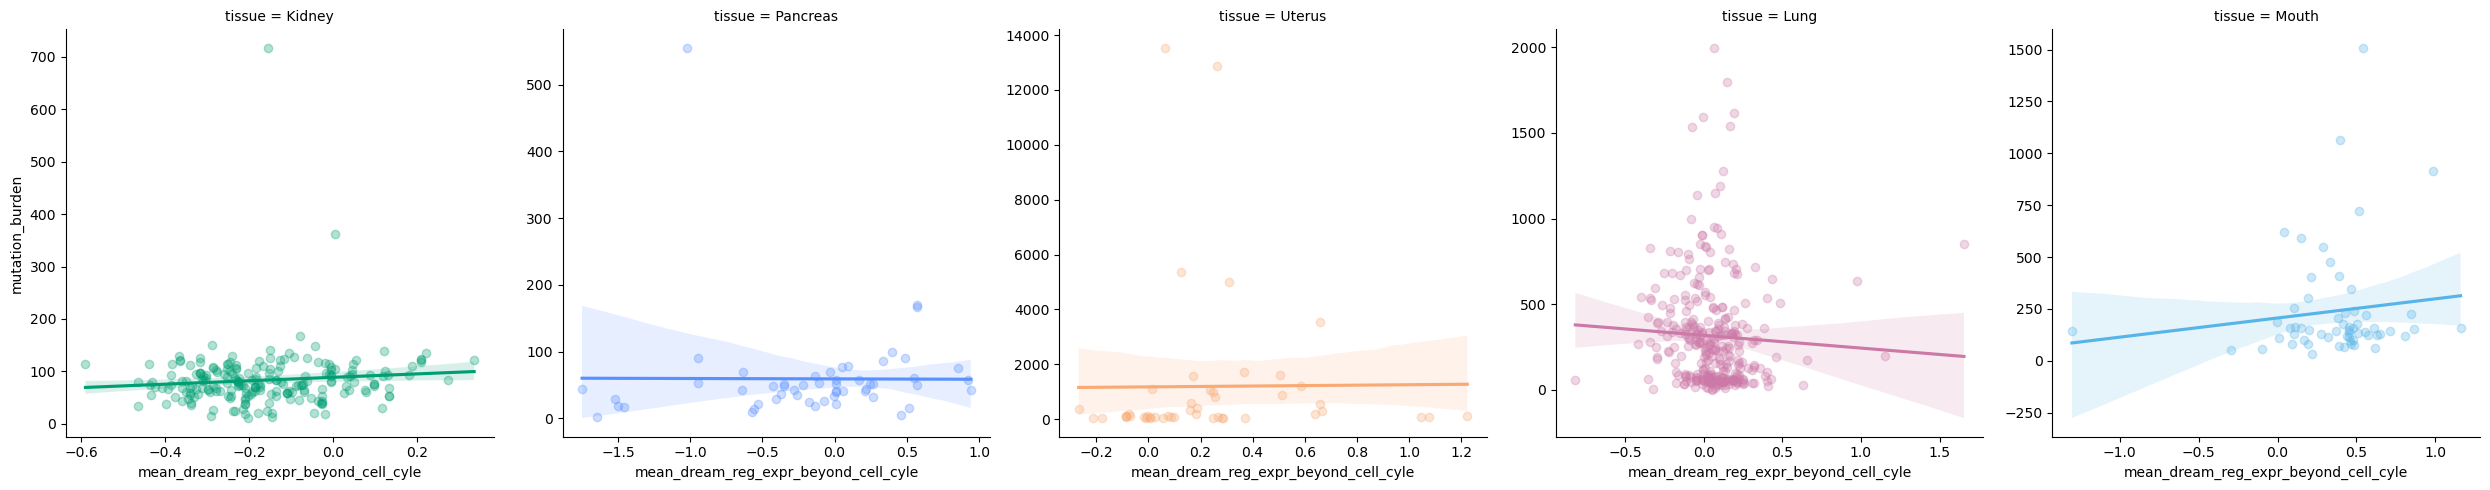

In [70]:
# control dream expression for S_score
# fit linear model
model = smf.ols(formula='mean_dream_reg_expr ~ S_score * G2M_score', data=normal_expr_v_burden)
results = model.fit()
# add residuals to dataframe
normal_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
sns.lmplot(
    data = normal_expr_v_burden,
    x = 'mean_dream_reg_expr_beyond_cell_cyle', y = 'mutation_burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
)